In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import json
import os
import itertools

In [2]:
def load_tweets(min_followers=None, tweet_path="data/tweet/raw"):
    dfs = []

    for symbol in tqdm(os.listdir(tweet_path)):
        for day in os.listdir(os.path.join(tweet_path, symbol)):
            file_path = os.path.join(tweet_path, symbol, day)

            with open(file_path) as f:
                content = f.readlines()
                d = list(map(json.loads, content))
                df = pd.DataFrame(d)

                if min_followers is not None:
                    df = df[df["user"].apply(lambda u: u["followers_count"]) > min_followers]
                
                if len(df) > 0:
                    dfs.append(df)

    tweets = pd.concat(dfs)
    print(f"Found {len(tweets)} tweets")

    simple_tweets = pd.DataFrame()
    simple_tweets["date"] = pd.to_datetime(tweets["created_at"])
    simple_tweets["text"] = tweets["text"].apply(lambda t: t.replace("\n", " "))
    simple_tweets["user_name"] = tweets["user"].apply(lambda u: u["name"])
    simple_tweets["user_followers"] = tweets["user"].apply(lambda u: u["followers_count"])
    simple_tweets["sym"] = tweets["entities"].apply(lambda entities: list(map(lambda s: s["text"], entities["symbols"])))

    return simple_tweets

# load_tweets(100000)

In [3]:
def load_prices(price_path="data/price/preprocessed"):
    dfs = []
    cols = ["date", "movement percent", "norm open price", "norm high price", "norm low price", "norm close price", "volume"]

    for symbol in tqdm(os.listdir(price_path)):
        file_path = os.path.join(price_path, symbol)

        df = pd.read_csv(file_path, sep="\t", names=cols)
        df["symbol"] = symbol.replace(".txt", "")
        dfs.append(df)

    prices = pd.concat(dfs, axis=0)
    prices['date'] = pd.to_datetime(prices['date'])
    prices = prices.set_index(['symbol', 'date'])
    return prices

# load_prices()

In [21]:
class Movement:
    def __init__(self, tweets, stock, price, day):
        self.tweets = tweets
        self.stock = stock
        self.price = price
        self.day = day

    def __repr__(self):
        return f"Movement of {self.stock} on {self.day.date()}: {len(self.tweets)} tweet(s)"

In [23]:
def load_movements(min_tweets_day=None):
    tweets = load_tweets()
    prices = load_prices()
    movements = []
    missing_prices = []

    for day in tqdm(prices.index.get_level_values('date').unique()):
        day = pd.to_datetime(day)
        todays_tweets = tweets[tweets['date'].dt.date == day]
        todays_stocks = pd.unique(list(itertools.chain(*todays_tweets["sym"])))
        for stock in todays_stocks:
            rel_tweets = todays_tweets[todays_tweets["sym"].apply(lambda x: stock in x)]
            try:
                movements.append(Movement(rel_tweets, stock, prices.loc[stock, day], day))
            except Exception as e:
                missing_prices.append(e)

    nr_movements = len(movements)

    if min_tweets_day is not None:
        movements = list(filter(lambda m: len(m.tweets) > min_tweets_day, movements))

    print(f"Loaded {nr_movements} movements, returning {len(movements)}. Found no price for {len(missing_prices)}.")

    return movements

# load_movements()


Found 119844 tweets



Loaded 21330 movements. Found no price for 67794.


: 1 tweets,
 Movement of MSFT on 2016-03-10: 13 tweets,
 Movement of FB on 2016-03-10: 30 tweets,
 Movement of GOOG on 2016-03-10: 22 tweets,
 Movement of AMZN on 2016-03-10: 11 tweets,
 Movement of AAPL on 2016-03-10: 43 tweets,
 Movement of ABBV on 2016-03-10: 3 tweets,
 Movement of TOT on 2016-03-10: 3 tweets,
 Movement of XOM on 2016-03-10: 3 tweets,
 Movement of CVX on 2016-03-10: 7 tweets,
 Movement of PICO on 2016-03-10: 1 tweets,
 Movement of ORCL on 2016-03-10: 1 tweets,
 Movement of MRK on 2016-03-10: 1 tweets,
 Movement of JPM on 2016-03-10: 2 tweets,
 Movement of BABA on 2016-03-10: 7 tweets,
 Movement of CSCO on 2016-03-10: 6 tweets,
 Movement of PCLN on 2016-03-10: 6 tweets,
 Movement of HON on 2016-03-10: 1 tweets,
 Movement of DIS on 2016-03-10: 1 tweets,
 Movement of WMT on 2016-03-10: 2 tweets,
 Movement of T on 2016-03-10: 2 tweets,
 Movement of VZ on 2016-03-10: 4 tweets,
 Movement of ABB on 2016-03-10: 1 tweets,
 Movement of BAC on 2016-03-10: 1 tweets,
 Movement o

(array([   0.,    0., 6368.,    0., 3559.,    0., 2232.,    0., 1566.,
           0., 1096.,    0.,  845.,    0.,  682.,    0.,  551.,    0.,
         486.,    0.,  378.,    0.,  321.,    0.,  286.,    0.,  219.,
           0.,  175.,    0.,  240.,    0.,  190.,    0.,  165.,    0.,
         187.,    0.,  142.,    0.,   88.,    0.,  114.,    0.,   87.,
           0.,   84.,    0.,   81.,    0.,   67.,    0.,   72.,    0.,
          67.,    0.,   63.,    0.,   46.,    0.,   46.,    0.,   45.,
           0.,   30.,    0.,   30.,    0.,   32.,    0.,   24.,    0.,
          43.,    0.,   36.,    0.,   32.,    0.,   19.,    0.,   24.,
           0.,   17.,    0.,   26.,    0.,   23.,    0.,   27.,    0.,
          13.,    0.,   16.,    0.,   17.,    0.,   16.,    0.,   20.,
          14.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5

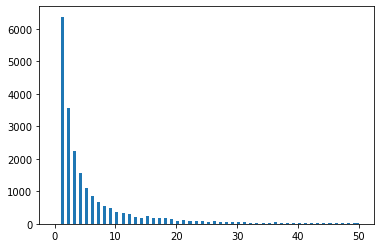

In [31]:
# import matplotlib.pyplot as plt
# plt.hist(list(map(lambda m: len(m.tweets), movements)), bins=100, range=(0,50))